In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import random_split
import time
from sklearn.utils.class_weight import compute_class_weight
import os
import time
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

In [59]:
domain = "All Domains"

In [63]:
# ======================
#  DATASET & NORMALIZATION
# ======================
train_dir = f'./data/{domain}/Training'

# Temporary loader for mean/std
temp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
temp_dataset = datasets.ImageFolder(train_dir, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=min(2, os.cpu_count() // 2), pin_memory=(device.type == "cuda"))

try:
    print("Attempting fast mean/std computation...")
    imgs = torch.cat([img for img, _ in temp_loader])
    mean, std = imgs.mean([0, 2, 3]), imgs.std([0, 2, 3])
    print("✅ Fast computation successful.")

except RuntimeError as e:
    print(f"⚠️ Fast method failed due to: {e}")
    print("Switching to safe incremental computation...")

    mean = 0.0
    std = 0.0
    nb_samples = 0

    for imgs, _ in temp_loader:
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)  # flatten HxW
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    print("✅ Safe incremental computation successful.")

print("Mean:", mean)
print("Std:", std)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=8),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Reload full dataset with final transforms
full_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=min(2, os.cpu_count() // 2), pin_memory=(device.type == "cuda"))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=min(2, os.cpu_count() // 2), pin_memory=(device.type == "cuda"))

print(f"Train images: {len(train_dataset)}, Validation images: {len(val_dataset)}")
print("Classes:", full_dataset.classes)

Attempting fast mean/std computation...
⚠️ Fast method failed due to: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "c:\Users\mwm06\anaconda3\envs\ai-prac\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 41, in do_one_step
    data = pin_memory(data, device)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mwm06\anaconda3\envs\ai-prac\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 98, in pin_memory
    clone[i] = pin_memory(item, device)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mwm06\anaconda3\envs\ai-prac\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 64, in pin_memory
    return data.pin_memory(device)
           ^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with 

In [64]:
# ======================
#  CLASS WEIGHTS
# ======================
train_labels = [full_dataset.samples[i][1] for i in train_dataset.indices]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# ======================
#  MODEL (ResNet-18 Transfer Learning)
# ======================
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, len(full_dataset.classes))
model = model.to(device)

# Optionally freeze early layers
for name, param in model.named_parameters():
    if "layer1" in name or "layer2" in name:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss(weight=weights) # More chill imbalance compensation, better for pretrained

# Typical optimizer and scheduler for pretrained, specifies steps and convergence
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)

# ======================
#  VALIDATION FUNCTION
# ======================
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return val_loss / len(val_loader), correct / total

model_path = os.path.join("models", f"{domain} Model.pth")
print(f"🧩 Saving model to: {model_path}")

# ======================
# TRAINING LOOP
# ======================
total_start = time.time()
best_val_loss = float('inf')
unfreeze_triggered = False
epochs_no_improve = 0
early_stop_patience = 7
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch + 1,
            "val_loss": val_loss,
            "training_time": time.time() - total_start,
            "std": std.tolist(),
            "mean": mean.tolist()
        }
        torch.save(checkpoint, model_path)
        print(f"💾 New best model saved (Val Loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f"🕒 No improvement for {epochs_no_improve} epoch(s)")

        # ----- Unfreeze after plateau -----
        if epochs_no_improve == 3 and not unfreeze_triggered:
            print("🔓 Unfreezing all layers for fine-tuning...")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
            unfreeze_triggered = True
        
        if epochs_no_improve >= early_stop_patience:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break

print(f"\n✅ Total Training Time: {(time.time()-total_start)/60:.2f} min")

🧩 Saving model to: models\All Domains Model.pth


Epoch [1/50]: 100%|██████████| 804/804 [01:52<00:00,  7.12it/s, loss=7.74e-5] 


Epoch [1/50] | Train Loss: 0.0096 | Val Loss: 0.0001 | Val Acc: 100.00%
💾 New best model saved (Val Loss: 0.0001)


Epoch [2/50]: 100%|██████████| 804/804 [04:54<00:00,  2.73it/s, loss=2.45e-5] 


Epoch [2/50] | Train Loss: 0.0002 | Val Loss: 0.0000 | Val Acc: 100.00%
💾 New best model saved (Val Loss: 0.0000)


Epoch [3/50]: 100%|██████████| 804/804 [01:24<00:00,  9.53it/s, loss=8.96e-6] 


Epoch [3/50] | Train Loss: 0.0001 | Val Loss: 0.0000 | Val Acc: 100.00%
💾 New best model saved (Val Loss: 0.0000)


Epoch [4/50]: 100%|██████████| 804/804 [01:05<00:00, 12.22it/s, loss=7.47e-5] 


Epoch [4/50] | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
💾 New best model saved (Val Loss: 0.0000)


Epoch [5/50]: 100%|██████████| 804/804 [01:07<00:00, 11.95it/s, loss=0.000467]


Epoch [5/50] | Train Loss: 0.0041 | Val Loss: 0.0730 | Val Acc: 99.25%
🕒 No improvement for 1 epoch(s)


Epoch [6/50]: 100%|██████████| 804/804 [01:07<00:00, 11.87it/s, loss=0.00154] 


Epoch [6/50] | Train Loss: 0.0036 | Val Loss: 0.0000 | Val Acc: 100.00%
🕒 No improvement for 2 epoch(s)


Epoch [7/50]: 100%|██████████| 804/804 [01:07<00:00, 11.94it/s, loss=4.23e-6] 


Epoch [7/50] | Train Loss: 0.0005 | Val Loss: 0.0000 | Val Acc: 100.00%
🕒 No improvement for 3 epoch(s)
🔓 Unfreezing all layers for fine-tuning...


Epoch [8/50]: 100%|██████████| 804/804 [01:12<00:00, 11.03it/s, loss=6.41e-6] 


Epoch [8/50] | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
💾 New best model saved (Val Loss: 0.0000)


Epoch [9/50]: 100%|██████████| 804/804 [01:35<00:00,  8.42it/s, loss=1.59e-6] 


Epoch [9/50] | Train Loss: 0.0001 | Val Loss: 0.0000 | Val Acc: 100.00%
🕒 No improvement for 1 epoch(s)


Epoch [10/50]: 100%|██████████| 804/804 [01:17<00:00, 10.37it/s, loss=1.28e-6] 


Epoch [10/50] | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
💾 New best model saved (Val Loss: 0.0000)


Epoch [11/50]: 100%|██████████| 804/804 [01:10<00:00, 11.47it/s, loss=3.81e-7] 


Epoch [11/50] | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
🕒 No improvement for 1 epoch(s)


Epoch [12/50]: 100%|██████████| 804/804 [01:09<00:00, 11.57it/s, loss=7.43e-7] 


Epoch [12/50] | Train Loss: 0.0001 | Val Loss: 0.0000 | Val Acc: 100.00%
🕒 No improvement for 2 epoch(s)


Epoch [13/50]: 100%|██████████| 804/804 [01:09<00:00, 11.53it/s, loss=1.92e-6] 


Epoch [13/50] | Train Loss: 0.0004 | Val Loss: 0.0000 | Val Acc: 100.00%
🕒 No improvement for 3 epoch(s)


Epoch [14/50]: 100%|██████████| 804/804 [01:11<00:00, 11.32it/s, loss=1.01e-6] 


Epoch [14/50] | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
🕒 No improvement for 4 epoch(s)


Epoch [15/50]: 100%|██████████| 804/804 [01:12<00:00, 11.04it/s, loss=6.81e-7] 


Epoch [15/50] | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
🕒 No improvement for 5 epoch(s)


Epoch [16/50]: 100%|██████████| 804/804 [01:12<00:00, 11.14it/s, loss=1.78e-6] 


Epoch [16/50] | Train Loss: 0.0001 | Val Loss: 0.0000 | Val Acc: 100.00%
🕒 No improvement for 6 epoch(s)


Epoch [17/50]: 100%|██████████| 804/804 [01:11<00:00, 11.19it/s, loss=2.68e-6] 


Epoch [17/50] | Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%
🕒 No improvement for 7 epoch(s)

🛑 Early stopping at epoch 17

✅ Total Training Time: 32.20 min


In [ ]:
# ======================
# LOAD SPECIFIC SAVED MODEL
# ======================

import os
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_dir = f"./data/{domain}/Testing"
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Re-create the same model architecture used during training
model_path = os.path.join("models", f"{domain}_Model.pth")

print(f"🧩 Loading pretrained ResNet-18 model from: {model_path}")

# Recreate the same architecture used during training
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, len(test_dataset.classes))
model = model.to(device)

# ✅ Load full checkpoint (not just weights)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
training_time = checkpoint.get("training_time", 0)
epoch_trained = checkpoint.get("epoch", "N/A")

print(f"✅ Model loaded from checkpoint trained for {training_time/60:.2f} minutes "
      f"({epoch_trained} epochs)")

# Set to evaluation mode
model.eval()
print("✅ Model ready for inference.")


✅ Test Accuracy: 100.00%

Classification Report:
                precision    recall  f1-score   support

 Blood Cancer       1.00      1.00      1.00       567
Bone Fracture       1.00      1.00      1.00       456
    Brain MRI       1.00      1.00      1.00       118
Breast Cancer       1.00      1.00      1.00      3989
   Chest Xray       1.00      1.00      1.00       624

     accuracy                           1.00      5754
    macro avg       1.00      1.00      1.00      5754
 weighted avg       1.00      1.00      1.00      5754



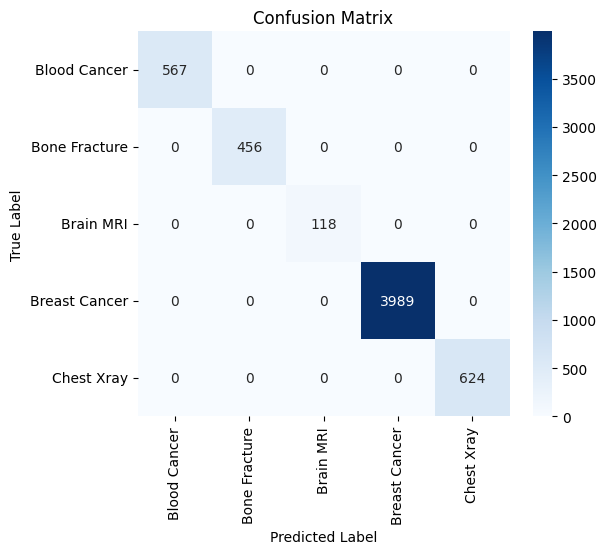

Per-class Precision: [1. 1. 1. 1.]
Per-class Recall: [1. 1. 1. 1.]
📄 Report saved to: reports\All Domains Eval Report.txt


In [65]:
# ======================
# TEST + REPORT
# ======================
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_dir = f"./data/{domain}/Testing"
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=min(2, os.cpu_count() // 2), pin_memory=(device.type == "cuda"))
class_names = test_dataset.classes

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true, y_pred = np.array(y_true), np.array(y_pred)
acc = (y_true == y_pred).sum() / len(y_true)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)

report_path = os.path.join("reports", f"{domain} Eval Report.txt")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

metrics = precision_recall_fscore_support(y_true, y_pred, labels=[0,1,2,3])
print("Per-class Precision:", metrics[0])
print("Per-class Recall:", metrics[1])

# ======================
# SAVE REPORT
# ======================
with open(report_path, "w") as f:
    f.write(f"Model file: {os.path.basename(model_path)}\n")
    f.write(f"Total Training Time: {training_time/60:.2f} minutes\n")
    f.write(f"\nTest Accuracy: {acc*100:.2f}%\n\n")
    f.write(report)
print(f"📄 Report saved to: {report_path}")